In [2]:

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow import keras
from tensorflow.keras.activations import swish
import shap



In [3]:
data = pd.read_csv('Normalised_NBA_Data.csv')

data.head()

,WL,PTS,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,...,PLUS_MINUS,PPM,POSSESSIONS,PTSperP,EFGPCT,PACE,HOME,Scoring_Opportunities,Defensive_Index,TO_to_AST_Ratio
0,1,0.484848,0.447368,0.622642,0.427,0.481481,0.603175,0.333,0.425,0.370370,...,0.686869,0.485437,0.543860,0.411052,0.437531,0.543771,1,0.581818,0.510638,0.280000
1,0,0.303030,0.368421,0.415094,0.449,0.407407,0.571429,0.297,0.175,0.240741,...,0.323232,0.300971,0.403509,0.332324,0.480281,0.403199,0,0.400000,0.276596,0.722222
2,1,0.646465,0.657895,0.660377,0.505,0.555556,0.571429,0.405,0.375,0.407407,...,0.888889,0.645631,0.578947,0.530659,0.632964,0.579125,1,0.600000,0.531915,0.380952
3,1,0.484848,0.447368,0.490566,0.463,0.629630,0.714286,0.370,0.325,0.259259,...,0.575758,0.485437,0.491228,0.447388,0.586635,0.491582,0,0.527273,0.361702,0.346154
4,0,0.414141,0.447368,0.566038,0.442,0.333333,0.380952,0.360,0.350,0.296296,...,0.434343,0.412621,0.561404,0.336866,0.424614,0.561448,1,0.390909,0.404255,0.533333


In [4]:
data.drop(['PLUS_MINUS'], axis=1, inplace=True)

In [5]:
data.head()

,WL,PTS,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,...,PF,PPM,POSSESSIONS,PTSperP,EFGPCT,PACE,HOME,Scoring_Opportunities,Defensive_Index,TO_to_AST_Ratio
0,1,0.484848,0.447368,0.622642,0.427,0.481481,0.603175,0.333,0.425,0.370370,...,0.242424,0.485437,0.543860,0.411052,0.437531,0.543771,1,0.581818,0.510638,0.280000
1,0,0.303030,0.368421,0.415094,0.449,0.407407,0.571429,0.297,0.175,0.240741,...,0.393939,0.300971,0.403509,0.332324,0.480281,0.403199,0,0.400000,0.276596,0.722222
2,1,0.646465,0.657895,0.660377,0.505,0.555556,0.571429,0.405,0.375,0.407407,...,0.303030,0.645631,0.578947,0.530659,0.632964,0.579125,1,0.600000,0.531915,0.380952
3,1,0.484848,0.447368,0.490566,0.463,0.629630,0.714286,0.370,0.325,0.259259,...,0.363636,0.485437,0.491228,0.447388,0.586635,0.491582,0,0.527273,0.361702,0.346154
4,0,0.414141,0.447368,0.566038,0.442,0.333333,0.380952,0.360,0.350,0.296296,...,0.303030,0.412621,0.561404,0.336866,0.424614,0.561448,1,0.390909,0.404255,0.533333


In [6]:
# Spliting the data into training and testing sets:

from sklearn.model_selection import train_test_split

X = data.drop('WL', axis=1)
y = data['WL']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Define the model function
def create_model(learning_rate=0.0001):
    model = keras.Sequential([
        keras.layers.Dense(128, input_shape=(X_train.shape[1],), activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(16, activation='relu'),
        keras.layers.Dense(8, activation='relu'),        
        keras.layers.Dense(1, activation='sigmoid')
    ])
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'precision', 'recall', 'AUC'])
    return model

# Wrap the model using KerasClassifier
model = KerasClassifier(model=create_model, verbose=0)

# Define the hyperparameter grid
param_grid = {
    'model__learning_rate': [0.0001, 0.001, 0.01],
    'batch_size': [8, 16, 32, 64],
    'epochs': [10, 25, 50, 100]
}

# Set up GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy')

# Fit the grid search
grid_result = grid.fit(X_train, y_train)

# Get the best parameters and the best score
print("Best Hyperparameters:", grid_result.best_params_)
print("Best Accuracy:", grid_result.best_score_)               


c:\Users\thoma\anaconda3\envs\conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\thoma\anaconda3\envs\conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\thoma\anaconda3\envs\conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regulariz

Best Hyperparameters: {'batch_size': 32, 'epochs': 25, 'model__learning_rate': 0.01}
Best Accuracy: 0.8435284669978138


In [8]:
model = keras.Sequential([
        keras.layers.Dense(128, input_shape=(X_train.shape[1],), activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(16, activation='relu'),
        keras.layers.Dense(8, activation='relu'),        
        keras.layers.Dense(1, activation='sigmoid')
    ])
    
optimizer = keras.optimizers.Adam(learning_rate=0.01)
    
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', 'precision', 'recall', 'AUC'])

c:\Users\thoma\anaconda3\envs\conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
model.fit(X_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - AUC: 0.8661 - accuracy: 0.7840 - loss: 0.4472 - precision: 0.7726 - recall: 0.8022
Epoch 2/25
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9120 - accuracy: 0.8282 - loss: 0.3759 - precision: 0.8342 - recall: 0.8146
Epoch 3/25
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9126 - accuracy: 0.8282 - loss: 0.3740 - precision: 0.8326 - recall: 0.8186
Epoch 4/25
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9174 - accuracy: 0.8350 - loss: 0.3641 - precision: 0.8339 - recall: 0.8302
Epoch 5/25
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9179 - accuracy: 0.8366 - loss: 0.3630 - precision: 0.8442 - recall: 0.8190
Epoch 6/25
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9184 - accuracy: 0.8391 - loss: 0.3624 - precision: 0.8452 - recall: 0.8265
Epoch 7/25
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9227 - accuracy: 0.8409 - loss: 0.3524 - precision: 0.8454 - recall: 0.8297
Epoch 8/25
1266/1266 ━━━━━

In [10]:
model.evaluate(X_test, y_test)

317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - AUC: 0.9306 - accuracy: 0.8431 - loss: 0.3434 - precision: 0.8694 - recall: 0.7954


[0.34444376826286316,
 0.8449229598045349,
 0.8740314245223999,
 0.7977369427680969,
 0.9297481179237366]

In [11]:
yp = model.predict(X_test)
yp[:10]

317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


array([[0.9532449 ],
       [0.5258741 ],
       [0.14224145],
       [0.43581742],
       [0.53518075],
       [0.22576165],
       [0.60540736],
       [0.5499342 ],
       [0.16983637],
       [0.04902602]], dtype=float32)

In [12]:
y_pred = []
for element in yp:
    if element >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)
y_pred[:10]

[1, 1, 0, 0, 1, 0, 1, 1, 0, 0]

In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.89      0.85      5175
           1       0.87      0.80      0.83      4949

    accuracy                           0.84     10124
   macro avg       0.85      0.84      0.84     10124
weighted avg       0.85      0.84      0.84     10124



Text(95.72222222222221, 0.5, 'Truths')

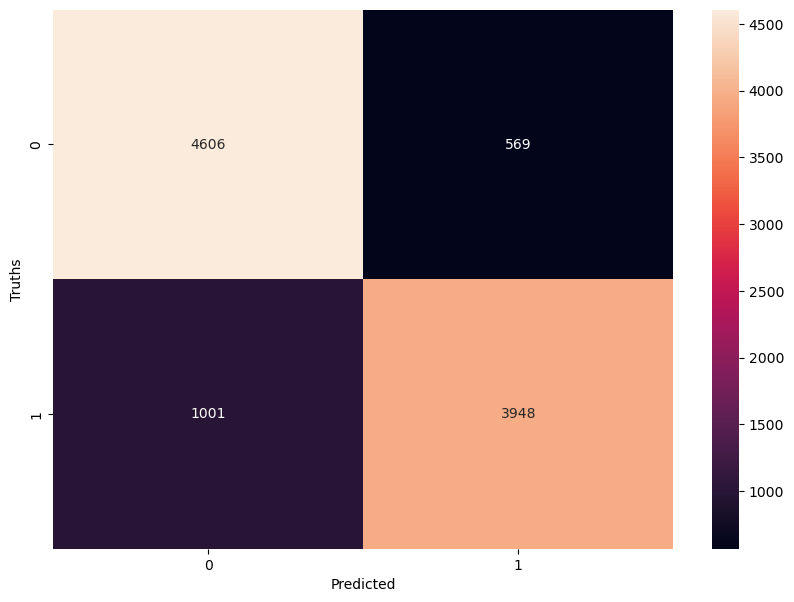

In [14]:
cm = tf.math.confusion_matrix(labels = y_test , predictions= y_pred)
plt.figure(figsize= (10 , 7))
sns.heatmap(cm , annot=True , fmt= 'd')
plt.xlabel("Predicted")
plt.ylabel("Truths")

c:\Users\thoma\anaconda3\envs\conda\Lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


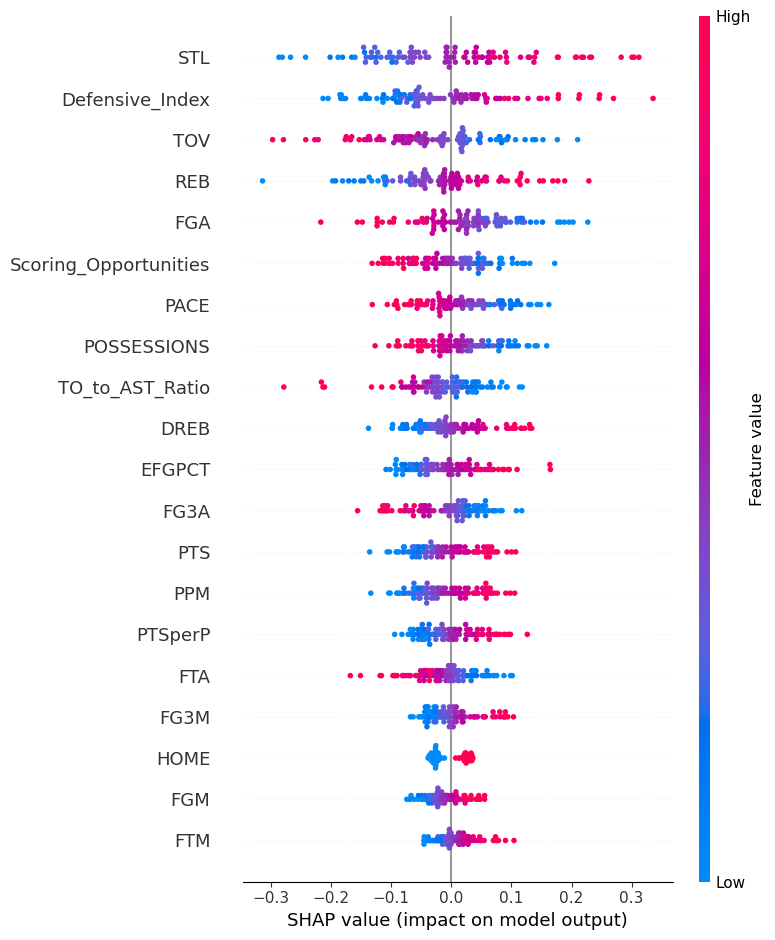

TypeError: Object of type EagerTensor is not JSON serializable

In [15]:
# Ensure feature_names matches the column order in X_train
feature_names = X_train.columns.tolist()



# SHAP Analysis
from tqdm import tqdm
import shap
# Function to make predictions
# Function to make predictions and ensure NumPy array outputs
def model_predict(X):
    return model.predict(X).flatten().astype(float)  # Ensure output is NumPy array


# Ensure X_test is in the correct format
if isinstance(X_test, pd.DataFrame):
    X_test_array = X_test.values  # Convert to NumPy array if it's a DataFrame
else:
    X_test_array = X_test  # Already a NumPy array

# Select background data for SHAP
if isinstance(X_train, pd.DataFrame):
    background_data = X_train.sample(100, random_state=42).values
else:
    background_data = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

# Initialize SHAP explainer
explainer = shap.DeepExplainer(model, background_data)

# Ensure all SHAP inputs are NumPy arrays
if isinstance(X_test, pd.DataFrame):
    X_test_array = X_test.values  # Convert DataFrame to NumPy array
else:
    X_test_array = X_test

# Generate SHAP values for all rows in X_test_array[:100]
shap_values = explainer.shap_values(X_test_array[:100])

# If shap_values is a list, extract the first element
if isinstance(shap_values, list):
    shap_values = shap_values[0]

# Reshape SHAP values to remove any extra dimensions
shap_values = shap_values.squeeze()  # Converts shape (100, 28, 1) to (100, 28)

# Visualize SHAP results
shap.summary_plot(shap_values, X_test_array[:100], feature_names=feature_names)

# Ensure NumPy arrays for force plot
shap.force_plot(
    explainer.expected_value[0], 
    shap_values[0], 
    X_test_array[0], 
    feature_names=feature_names
)

In [16]:
# Reduction of Dataset to match the SHAP values in the model:

reduced_data = data[["WL","STL", "Defensive_Index", "REB", "TOV","FGA","TO_to_AST_Ratio", "Scoring_Opportunities", "POSSESSIONS"
                     ,"FG3A","PACE", "PPM","PTS", "EFGPCT", "FTA", "PTSperP"]]

reduced_data.head()

,WL,STL,Defensive_Index,REB,TOV,FGA,TO_to_AST_Ratio,Scoring_Opportunities,POSSESSIONS,FG3A,PACE,PPM,PTS,EFGPCT,FTA,PTSperP
0,1,0.500000,0.510638,0.674419,0.214286,0.622642,0.280000,0.581818,0.543860,0.603175,0.543771,0.485437,0.484848,0.437531,0.370370,0.411052
1,0,0.222222,0.276596,0.302326,0.428571,0.415094,0.722222,0.400000,0.403509,0.571429,0.403199,0.300971,0.303030,0.480281,0.240741,0.332324
2,1,0.388889,0.531915,0.697674,0.250000,0.660377,0.380952,0.600000,0.578947,0.571429,0.579125,0.645631,0.646465,0.632964,0.407407,0.530659
3,1,0.222222,0.361702,0.325581,0.285714,0.490566,0.346154,0.527273,0.491228,0.714286,0.491582,0.485437,0.484848,0.586635,0.259259,0.447388
4,0,0.277778,0.404255,0.488372,0.250000,0.566038,0.533333,0.390909,0.561404,0.380952,0.561448,0.412621,0.414141,0.424614,0.296296,0.336866


In [17]:
X = reduced_data.drop('WL', axis=1)
y = reduced_data['WL']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
X_train.shape , X_test.shape , y_train.shape , y_test.shape 

((40493, 15), (10124, 15), (40493,), (10124,))

In [ ]:
# Define the model function
def create_model(learning_rate=0.01):
    model = keras.Sequential([
        keras.layers.Dense(128, input_shape=(X_train.shape[1],), activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(16, activation='relu'),
        keras.layers.Dense(8, activation='relu'),        
        keras.layers.Dense(1, activation='sigmoid')
    ])
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'precision', 'recall', 'AUC'])
    return model

# Wrap the model using KerasClassifier
model = KerasClassifier(model=create_model, verbose=0)

# Define the hyperparameter grid
param_grid = {
    'model__learning_rate': [0.0001, 0.001, 0.01],
    'batch_size': [8, 16, 32, 64],
    'epochs': [10, 25, 50, 100]
}

# Set up GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy')

# Fit the grid search
grid_result = grid.fit(X_train, y_train)

# Get the best parameters and the best score
print("Best Hyperparameters:", grid_result.best_params_)
print("Best Accuracy:", grid_result.best_score_)    


c:\Users\thoma\anaconda3\envs\conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\thoma\anaconda3\envs\conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\thoma\anaconda3\envs\conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regulariz

Best Hyperparameters: {'batch_size': 64, 'epochs': 50, 'model__learning_rate': 0.001}
Best Accuracy: 0.8413058423220212


In [ ]:
model = keras.Sequential([
        keras.layers.Dense(128, input_shape=(X_train.shape[1],), activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(16, activation='relu'),
        keras.layers.Dense(8, activation='relu'),        
        keras.layers.Dense(1, activation='sigmoid')
    ])
    
optimizer = keras.optimizers.Adam(learning_rate=0.001)
    
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', 'precision', 'recall', 'AUC'])

c:\Users\thoma\anaconda3\envs\conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
model.fit(X_train, y_train, epochs=50, batch_size=64)

Epoch 1/50
633/633 ━━━━━━━━━━━━━━━━━━━━ 62s 4ms/step - AUC: 0.8639 - accuracy: 0.7941 - loss: 0.4650 - precision: 0.7977 - recall: 0.7825
Epoch 2/50
633/633 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9180 - accuracy: 0.8365 - loss: 0.3628 - precision: 0.8385 - recall: 0.8316
Epoch 3/50
633/633 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9213 - accuracy: 0.8376 - loss: 0.3554 - precision: 0.8395 - recall: 0.8336
Epoch 4/50
633/633 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9195 - accuracy: 0.8387 - loss: 0.3590 - precision: 0.8436 - recall: 0.8315
Epoch 5/50
633/633 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9205 - accuracy: 0.8376 - loss: 0.3565 - precision: 0.8430 - recall: 0.8243
Epoch 6/50
633/633 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9198 - accuracy: 0.8357 - loss: 0.3585 - precision: 0.8392 - recall: 0.8266
Epoch 7/50
633/633 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9210 - accuracy: 0.8379 - loss: 0.3555 - precision: 0.8408 - recall: 0.8276
Epoch 8/50
633/633 ━━━━━━━━━━━━━━━━━━━━ 

In [23]:
model.evaluate(X_test, y_test)

317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9277 - accuracy: 0.8454 - loss: 0.3425 - precision: 0.8379 - recall: 0.8446


[0.3435688018798828,
 0.8425523638725281,
 0.8358358144760132,
 0.8436047434806824,
 0.9266421794891357]

In [24]:
yp = model.predict(X_test)
yp[:10]

317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


array([[0.94813675],
       [0.62112296],
       [0.18080503],
       [0.46704394],
       [0.70374215],
       [0.15841457],
       [0.7269796 ],
       [0.83140683],
       [0.20603348],
       [0.03899516]], dtype=float32)

In [25]:
y_pred = []
for element in yp:
    if element >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)
y_pred[:10]

[1, 1, 0, 0, 1, 0, 1, 1, 0, 0]

In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.84      0.85      5175
           1       0.84      0.84      0.84      4949

    accuracy                           0.84     10124
   macro avg       0.84      0.84      0.84     10124
weighted avg       0.84      0.84      0.84     10124



Text(95.72222222222221, 0.5, 'Truths')

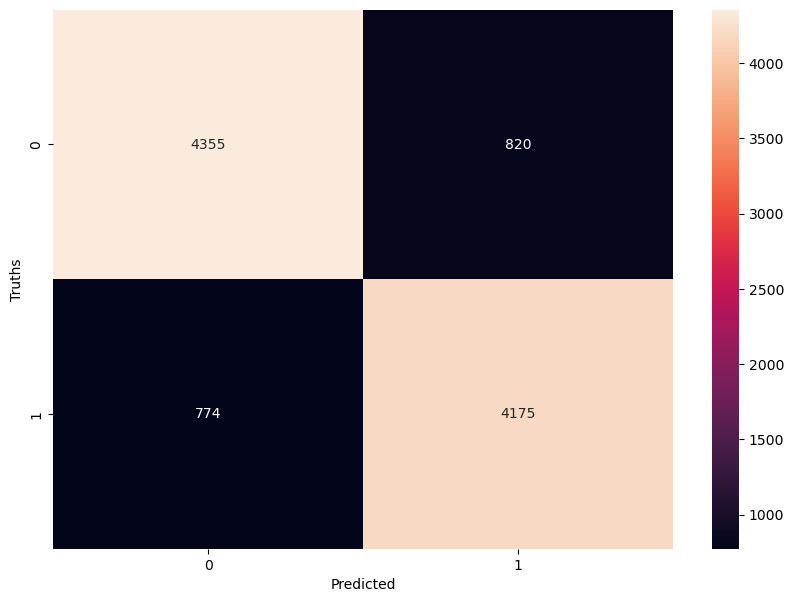

In [27]:
cm = tf.math.confusion_matrix(labels = y_test , predictions= y_pred)
plt.figure(figsize= (10 , 7))
sns.heatmap(cm , annot=True , fmt= 'd')
plt.xlabel("Predicted")
plt.ylabel("Truths")

c:\Users\thoma\anaconda3\envs\conda\Lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


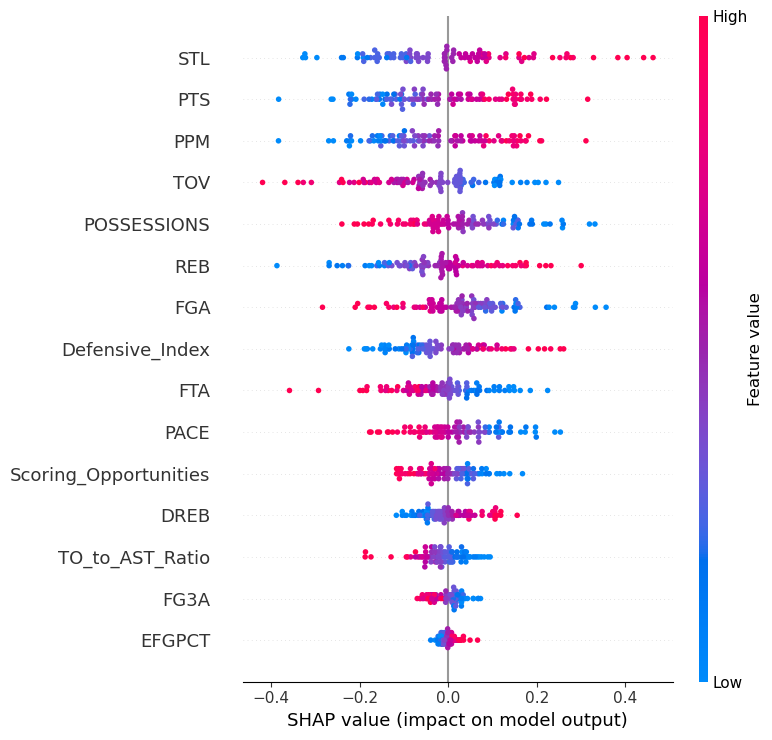

TypeError: Object of type EagerTensor is not JSON serializable

In [28]:
# Ensure feature_names matches the column order in X_train
feature_names = X_train.columns.tolist()



# SHAP Analysis
from tqdm import tqdm
import shap
# Function to make predictions
# Function to make predictions and ensure NumPy array outputs
def model_predict(X):
    return model.predict(X).flatten().astype(float)  # Ensure output is NumPy array


# Ensure X_test is in the correct format
if isinstance(X_test, pd.DataFrame):
    X_test_array = X_test.values  # Convert to NumPy array if it's a DataFrame
else:
    X_test_array = X_test  # Already a NumPy array

# Select background data for SHAP
if isinstance(X_train, pd.DataFrame):
    background_data = X_train.sample(100, random_state=42).values
else:
    background_data = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

# Initialize SHAP explainer
explainer = shap.DeepExplainer(model, background_data)

# Ensure all SHAP inputs are NumPy arrays
if isinstance(X_test, pd.DataFrame):
    X_test_array = X_test.values  # Convert DataFrame to NumPy array
else:
    X_test_array = X_test

# Generate SHAP values for all rows in X_test_array[:100]
shap_values = explainer.shap_values(X_test_array[:100])

# If shap_values is a list, extract the first element
if isinstance(shap_values, list):
    shap_values = shap_values[0]

# Reshape SHAP values to remove any extra dimensions
shap_values = shap_values.squeeze()  # Converts shape (100, 28, 1) to (100, 28)

# Visualize SHAP results
shap.summary_plot(shap_values, X_test_array[:100], feature_names=feature_names)

# Ensure NumPy arrays for force plot
shap.force_plot(
    explainer.expected_value[0], 
    shap_values[0], 
    X_test_array[0], 
    feature_names=feature_names
)